# 在合成数据上进行统计预测

在这个lab中，我会做一些统计预测，以便和后面的机器学习模型作比较

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

### Utilities

In [3]:
# plot function
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(5, 3))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

In [4]:
def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish
    
    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according 
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

### Generate the synthetic data

之后我会利用上面的工具函数来生成合成数据。这将会从一个简单的baseline开始，然后会有上升趋势，每365步采用季节性pattern。还会增加一些噪音，因为现实世界的数据通常是有噪音的。

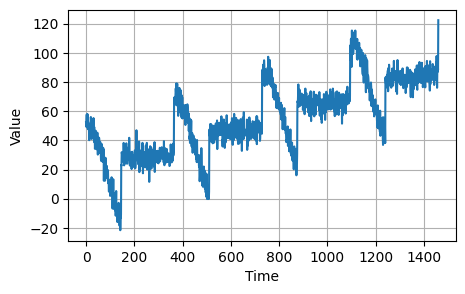

In [5]:
# Parameters
time = np.arange(4 * 365 + 1, dtype='float32')
baseline = 10
amplitude = 40   # 波幅
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# add noise
series += noise(time, noise_level, seed=42)

# plot the synthetic data
plot_series(time, series)

### Split the dataset

In [6]:
# Define the split time
split_time = 1000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Vaildation set
time_valid = time[split_time:]
x_valid = series[split_time:]

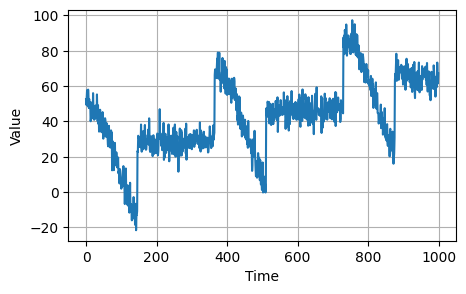

In [7]:
# plot the train set
plot_series(time_train, x_train)

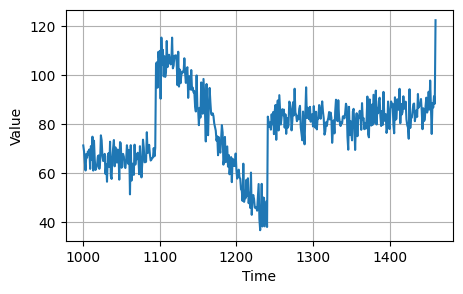

In [8]:
# plot the validation set
plot_series(time_valid, x_valid)

### Naive Forecast(朴素预测法)

使用朴素预测法作为baseline, 所谓朴素预测法是指要预测的值与上一个时间步相等。

In [9]:
# Generate the naive forecast
naive_forecast = series[split_time-1:-1]

# define time step
time_step = 100

# Print values
print(f'ground truth at time step {time_step}: {x_valid[time_step]}')
print(f'prediction at time step {time_step + 1}: {naive_forecast[time_step + 1]}')

ground truth at time step 100: 109.84197998046875
prediction at time step 101: 109.84197998046875


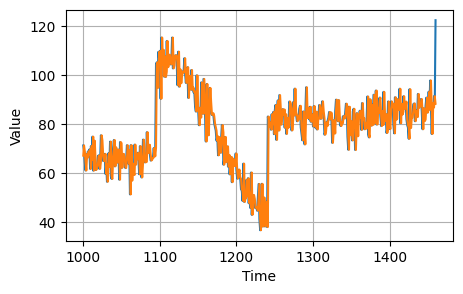

In [10]:
# Plot the results
plot_series(time_valid, (x_valid, naive_forecast))

### Computing Metrics

In [11]:
print(f"mse: {tf.metrics.mean_squared_error(x_valid, naive_forecast).numpy()}")
print(f"mae: {tf.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()}")

mse: 61.82753372192383
mae: 5.937908172607422


### Moving Average(移动平均法)

移动平均法又叫滑动平均法，取前面n个点的平均值作为预测值。例如，取时间步1-10的平均值作为时间步11的预测值。

In [12]:
def moving_average_forecast(series, window_size):
    """
    Generate a moving average forecast

    Args:
        series: contains the values of the time series
        window_size: the number of time steps to compute the average 

    Returns:
        forecast: the moving average forecast
    """

    forecast = []

    # Compute the average based on window size
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())

    forecast = np.array(forecast)

    return forecast

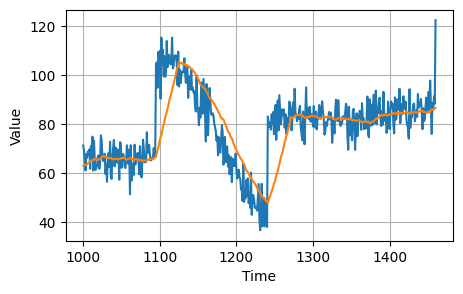

In [13]:
# Generate the moving average forecast
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

# Plot the results
plot_series(time_valid, (x_valid, moving_avg))

In [14]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

106.674576
7.142419
